# Análisis de Rendimiento: Minero Proof-of-Work

**Objetivo:** Comparar el rendimiento de tres modos de ejecución (Sequential, Concurrent, Parallel) con diferentes configuraciones de hilos y dificultades.

Este notebook puede analizar:
- Una sola carpeta de experimento (Experiment_*)
- Múltiples carpetas (promedios entre ejecuciones de diferentes PCs)

## Diseño Experimental
- **Modos:** Sequential (1 hilo), Concurrent (2/4/8 hilos con CPU pinning), Parallel (2/4/8 hilos multi-core)
- **Dificultades:** LOW (20 bits), MED (22 bits), HIGH (24 bits)
- **Configuraciones:** 21 combinaciones
- **Repeticiones:** 5 por configuración
- **Total de ejecuciones por experimento:** 105

## Índice
1. [Carga de Datos](#carga)
2. [Estadísticas Descriptivas](#estadisticas)
3. [Análisis Comparativo por Modo](#comparativo)
4. [Análisis por Dificultad](#dificultad)
5. [Análisis por Número de Hilos](#hilos)
6. [Speedup y Eficiencia](#speedup)
7. [Análisis Estadístico](#estadistico)
8. [Visualizaciones](#visualizaciones)
9. [Conclusiones](#conclusiones)

## 1. Carga de Datos

Cargamos todos los resultados experimentales desde una o más carpetas de experimento.

### 1.1. Configuración de Carpetas

Especifica las carpetas de experimento a analizar:
- `None`: Buscar automáticamente todas las carpetas `Experiment_*` en `results/`
- `[\"Experiment_...\"]`: Lista específica de carpetas
- `"latest"`: Usar únicamente la carpeta más reciente

In [5]:
# Configuración: Carpetas de experimento a analizar
# Opciones:
#   None: Todas las carpetas Experiment_* disponibles
#   "latest": Únicamente la carpeta más reciente
#   ["Experiment_...", ...]: Lista específica

EXPERIMENT_FOLDERS = None  # Analizar todas las carpetas disponibles
# EXPERIMENT_FOLDERS = "latest"  # Solo la más reciente
# EXPERIMENT_FOLDERS = ["Experiment_20251202_143025_AMD_Ryzen_7_32GB"]  # Específica

print(f"Configuración: {EXPERIMENT_FOLDERS}")

Configuración: None


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [7]:
# Rutas del proyecto
ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
RESULTS_DIR = ROOT / 'results'

print(f"Directorio raíz: {ROOT}")
print(f"Directorio de resultados: {RESULTS_DIR}")

Directorio raíz: c:\d\Proyectos_programacion\SO_Proyecto_Final
Directorio de resultados: c:\d\Proyectos_programacion\SO_Proyecto_Final\results


In [8]:
# Detectar carpetas de experimento disponibles
experiment_folders = sorted([d for d in RESULTS_DIR.iterdir() if d.is_dir() and d.name.startswith('Experiment_')])

print(f"Carpetas de experimento encontradas: {len(experiment_folders)}")
for folder in experiment_folders:
    print(f"  - {folder.name}")

if len(experiment_folders) == 0:
    print("\n⚠️ No se encontraron carpetas de experimento.")
    print("   Ejecuta primero los experimentos con: .\\scripts\\run_all_modes.ps1")
else:
    # Determinar qué carpetas analizar
    if EXPERIMENT_FOLDERS == "latest":
        folders_to_analyze = [experiment_folders[-1]]
        print(f"\n🔍 Analizando únicamente la carpeta más reciente: {folders_to_analyze[0].name}")
    elif EXPERIMENT_FOLDERS is None:
        folders_to_analyze = experiment_folders
        print(f"\n🔍 Analizando todas las carpetas ({len(folders_to_analyze)})")
    else:
        folders_to_analyze = [RESULTS_DIR / name for name in EXPERIMENT_FOLDERS if (RESULTS_DIR / name).exists()]
        print(f"\n🔍 Analizando carpetas específicas: {len(folders_to_analyze)}")
        for folder in folders_to_analyze:
            print(f"  - {folder.name}")
    
    # Cargar datos de todas las carpetas seleccionadas
    dfs = []
    total_files = 0
    
    for exp_folder in folders_to_analyze:
        raw_dir = exp_folder / 'raw'
        if not raw_dir.exists():
            print(f"\n⚠️ Carpeta raw/ no encontrada en {exp_folder.name}")
            continue
        
        csv_files = list(raw_dir.glob('exp_*.csv'))
        print(f"\n{exp_folder.name}: {len(csv_files)} archivos CSV")
        total_files += len(csv_files)
        
        for csv_file in csv_files:
            try:
                df = pd.read_csv(csv_file)
                # Extraer información del nombre del archivo
                filename = csv_file.stem
                parts = filename.split('_')
                if len(parts) >= 4:
                    df['experiment_id'] = '_'.join(parts[:4])  # exp_mode_threads_difficulty
                else:
                    df['experiment_id'] = '_'.join(parts[:3])  # fallback
                df['run_id'] = filename
                df['experiment_folder'] = exp_folder.name
                dfs.append(df)
            except Exception as e:
                print(f"  ⚠️ Error al cargar {csv_file.name}: {e}")
    
    if dfs:
        all_data = pd.concat(dfs, ignore_index=True)
        
        # Normalizar nombres de columnas
        if 'elapsed_s' in all_data.columns:
            all_data['elapsed_time_s'] = all_data['elapsed_s']
        if 'hashes_per_second' in all_data.columns:
            all_data['throughput_hashes_per_sec'] = all_data['hashes_per_second']
        
        print(f"\n✅ Datos cargados: {len(all_data)} registros de {total_files} archivos")
        print(f"   Carpetas analizadas: {len(folders_to_analyze)}")
        print(f"   Experimentos por carpeta: {all_data.groupby('experiment_folder').size().to_dict()}")
        print(f"\nColumnas disponibles: {list(all_data.columns)}")
    else:
        print("\n❌ No se pudieron cargar los datos")

Carpetas de experimento encontradas: 1
  - Experiment_20251202_202005_AMD_Ryzen_7_5700X_8-Core_Processor__32GB

🔍 Analizando todas las carpetas (1)

Experiment_20251202_202005_AMD_Ryzen_7_5700X_8-Core_Processor__32GB: 105 archivos CSV

✅ Datos cargados: 105 registros de 105 archivos
   Carpetas analizadas: 1
   Experimentos por carpeta: {'Experiment_20251202_202005_AMD_Ryzen_7_5700X_8-Core_Processor__32GB': 105}

Columnas disponibles: ['experiment_id', 'mode', 'difficulty', 'threads', 'affinity', 'found', 'nonce', 'total_hashes', 'elapsed_s', 'cpu_time_s', 'memory_mb', 'hashes_per_second', 'run_id', 'experiment_folder', 'elapsed_time_s', 'throughput_hashes_per_sec']


In [9]:
# Vista preliminar de los datos
if 'all_data' in locals():
    print("Primeras filas del dataset:")
    display(all_data.head(10))
    
    print(f"\nDimensiones: {all_data.shape[0]} filas × {all_data.shape[1]} columnas")
    print(f"\nCarpetas de experimento: {all_data['experiment_folder'].nunique()}")
    print(f"Experimentos únicos: {all_data['experiment_id'].nunique()}")
    
    if all_data['experiment_folder'].nunique() > 1:
        print(f"\nDistribución por carpeta:")
        display(all_data.groupby('experiment_folder')['experiment_id'].value_counts().head(20))

Primeras filas del dataset:


,experiment_id,mode,difficulty,threads,affinity,found,nonce,total_hashes,elapsed_s,cpu_time_s,memory_mb,hashes_per_second,run_id,experiment_folder,elapsed_time_s,throughput_hashes_per_sec
0,exp_con_2t_high,concurrent,24,2,True,True,4773626.0,9392921,11.669600,11.234400,7.92578,804904.0,exp_con_2t_high_run_20251202T202005Z_rep1,Experiment_20251202_202005_AMD_Ryzen_7_5700X_8...,11.669600,804904.0
1,exp_con_2t_high,concurrent,24,2,True,True,4773626.0,9410757,11.955500,11.546900,7.91797,787148.0,exp_con_2t_high_run_20251202T202022Z_rep2,Experiment_20251202_202005_AMD_Ryzen_7_5700X_8...,11.955500,787148.0
2,exp_con_2t_high,concurrent,24,2,True,True,4773626.0,9449690,12.098900,11.593800,7.92188,781040.0,exp_con_2t_high_run_20251202T202039Z_rep3,Experiment_20251202_202005_AMD_Ryzen_7_5700X_8...,12.098900,781040.0
3,exp_con_2t_high,concurrent,24,2,True,True,4773626.0,9451649,11.769300,11.390600,7.91406,803076.0,exp_con_2t_high_run_20251202T202055Z_rep4,Experiment_20251202_202005_AMD_Ryzen_7_5700X_8...,11.769300,803076.0
4,exp_con_2t_high,concurrent,24,2,True,True,4773626.0,9435144,11.670300,11.484400,7.91406,808473.0,exp_con_2t_high_run_20251202T202112Z_rep5,Experiment_20251202_202005_AMD_Ryzen_7_5700X_8...,11.670300,808473.0
5,exp_con_2t_low,concurrent,20,2,True,True,143773.0,277200,0.343970,0.328125,7.90625,805884.0,exp_con_2t_low_run_20251202T202128Z_rep1,Experiment_20251202_202005_AMD_Ryzen_7_5700X_8...,0.343970,805884.0
6,exp_con_2t_low,concurrent,20,2,True,True,143773.0,304418,0.375757,0.343750,7.91016,810146.0,exp_con_2t_low_run_20251202T202134Z_rep2,Experiment_20251202_202005_AMD_Ryzen_7_5700X_8...,0.375757,810146.0
7,exp_con_2t_low,concurrent,20,2,True,True,143773.0,302586,0.373756,0.375000,7.89062,809581.0,exp_con_2t_low_run_20251202T202139Z_rep3,Experiment_20251202_202005_AMD_Ryzen_7_5700X_8...,0.373756,809581.0
8,exp_con_2t_low,concurrent,20,2,True,True,143773.0,283443,0.427825,0.437500,7.89062,662520.0,exp_con_2t_low_run_20251202T202144Z_rep4,Experiment_20251202_202005_AMD_Ryzen_7_5700X_8...,0.427825,662520.0
9,exp_con_2t_low,concurrent,20,2,True,True,143773.0,280725,0.421027,0.406250,7.89062,666762.0,exp_con_2t_low_run_20251202T202149Z_rep5,Experiment_20251202_202005_AMD_Ryzen_7_5700X_8...,0.421027,666762.0



Dimensiones: 105 filas × 16 columnas

Carpetas de experimento: 1
Experimentos únicos: 21


### 1.2. Agregación de Múltiples Experimentos

Si hay múltiples carpetas de experimento, agregamos los datos calculando promedios por configuración.

In [10]:
if 'all_data' in locals() and all_data['experiment_folder'].nunique() > 1:
    print("=== AGREGACIÓN DE MÚLTIPLES CARPETAS ===\n")
    print(f"Carpetas detectadas: {all_data['experiment_folder'].nunique()}")
    print(f"Total de registros: {len(all_data)}\n")
    
    # Mostrar distribución de ejecuciones por carpeta y configuración
    print("Distribución de ejecuciones por carpeta:")
    dist = all_data.groupby(['experiment_folder', 'experiment_id']).size().unstack(fill_value=0)
    display(dist)
    
    # Calcular estadísticas agregadas por configuración
    print("\n📊 Calculando promedios entre carpetas de experimento...")
    
    # Agrupar por configuración y calcular estadísticas
    agg_data = all_data.groupby(['experiment_id', 'mode', 'difficulty', 'threads', 'affinity']).agg({
        'throughput_hashes_per_sec': ['mean', 'std', 'count'],
        'elapsed_time_s': ['mean', 'std'],
        'cpu_time_s': ['mean', 'std'],
        'memory_mb': ['mean', 'std'],
        'total_hashes': ['mean', 'std']
    }).reset_index()
    
    # Aplanar nombres de columnas
    agg_data.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in agg_data.columns.values]
    
    print(f"✅ Datos agregados: {len(agg_data)} configuraciones únicas")
    print(f"   Promediados desde {all_data['experiment_folder'].nunique()} carpetas")
    print(f"\nColumnas agregadas:")
    display(agg_data.head(10))
    
    # Mantener all_data original para análisis detallados
    all_data_detailed = all_data.copy()
    
    # Crear versión simplificada con promedios para análisis principal
    all_data_aggregated = agg_data.rename(columns={
        'throughput_hashes_per_sec_mean': 'throughput_hashes_per_sec',
        'throughput_hashes_per_sec_std': 'throughput_std',
        'elapsed_time_s_mean': 'elapsed_time_s',
        'elapsed_time_s_std': 'elapsed_time_std',
        'cpu_time_s_mean': 'cpu_time_s',
        'memory_mb_mean': 'memory_mb',
        'total_hashes_mean': 'total_hashes',
        'throughput_hashes_per_sec_count': 'n_samples'
    })
    
    print(f"\n💡 Usando datos agregados para análisis. Desviaciones estándar disponibles.")
    print(f"   Variables: *_std contienen desviación estándar entre carpetas")
    print(f"   all_data_detailed: Datos originales sin agregar")
    print(f"   all_data_aggregated: Datos promediados por configuración")
    
elif 'all_data' in locals():
    print("=== CARPETA ÚNICA ===")
    print("Analizando datos de una sola carpeta de experimento.")
    print("No se requiere agregación.")
    all_data_detailed = all_data.copy()
    all_data_aggregated = all_data.copy()
    all_data_aggregated['n_samples'] = 1

=== CARPETA ÚNICA ===
Analizando datos de una sola carpeta de experimento.
No se requiere agregación.


## 2. Estadísticas Descriptivas

Análisis descriptivo de las métricas principales.

In [11]:
# Resumen estadístico general
if 'all_data' in locals():
    metrics = ['elapsed_time_s', 'throughput_hashes_per_sec', 'cpu_time_s', 'memory_mb']
    
    print("=== RESUMEN ESTADÍSTICO GENERAL ===")
    print("\nMétricas principales:")
    display(all_data[metrics].describe())
    
    # Resumen por modo de ejecución
    print("\n=== RESUMEN POR MODO DE EJECUCIÓN ===")
    for metric in ['throughput_hashes_per_sec', 'elapsed_time_s']:
        print(f"\n{metric.upper()}:")
        summary = all_data.groupby('mode')[metric].agg(['count', 'mean', 'std', 'min', 'max'])
        display(summary)

=== RESUMEN ESTADÍSTICO GENERAL ===

Métricas principales:


,elapsed_time_s,throughput_hashes_per_sec,cpu_time_s,memory_mb
count,105.000000,1.050000e+02,105.000000,105.000000
mean,5.995482,1.313017e+06,11.695835,7.925297
std,11.093860,9.416386e+05,21.532130,0.044014
min,0.176258,4.856120e+05,0.250000,7.843750
25%,0.293984,7.378590e+05,0.562500,7.902340
50%,0.742877,8.058840e+05,1.250000,7.917970
75%,9.298050,1.836400e+06,11.546900,7.949220
max,48.051100,3.496720e+06,88.562500,8.046880



=== RESUMEN POR MODO DE EJECUCIÓN ===

THROUGHPUT_HASHES_PER_SEC:


,count,mean,std,min,max
mode,,,,,
concurrent,45,7.495460e+05,44719.362830,630500.0,810146.0
parallel,45,2.104411e+06,981268.396833,942441.0,3496720.0
sequential,15,6.292510e+05,140352.783066,485612.0,827542.0



ELAPSED_TIME_S:


,count,mean,std,min,max
mode,,,,,
concurrent,45,9.766462,15.520470,0.343970,48.05110
parallel,45,3.514215,4.660604,0.176258,11.11020
sequential,15,2.126347,2.718683,0.243157,6.00026


In [12]:
# Distribución de configuraciones
if 'all_data' in locals():
    print("=== CONFIGURACIONES EXPERIMENTALES ===")
    
    config_summary = all_data.groupby(['mode', 'threads', 'difficulty']).agg({
        'run_id': 'count',
        'throughput_hashes_per_sec': ['mean', 'std'],
        'elapsed_time_s': ['mean', 'std']
    }).round(2)
    
    config_summary.columns = ['n_runs', 'throughput_mean', 'throughput_std', 'time_mean', 'time_std']
    display(config_summary)

=== CONFIGURACIONES EXPERIMENTALES ===


n_runs  throughput_mean  throughput_std  \
mode       threads difficulty                                            
concurrent 2       20               5         750978.6        78846.35   
                   22               5         694332.4        23743.94   
                   24               5         796928.2        12070.40   
           4       20               5         739140.0        13828.40   
                   22               5         745349.6         8652.03   
                   24               5         790660.6         1876.78   
           8       20               5         704458.6        42649.86   
                   22               5         743988.8        18133.30   
                   24               5         780076.8         4423.41   
parallel   2       20               5        1055084.4        99322.66   
                   22               5        1018667.2        27880.72   
                   24               5        1051774.0        45840.51   
           4       20               5        1872038.0        78198.27   
                   22               5        1945644.0        48168.75   
                   24               5        1844446.0        13968.73   
           8       20               5        3356612.0        82123.75   
                   22               5        3413722.0        48252.20   
                   24               5        3381712.0        24929.28   
sequential 1       20               5         528095.0        41002.32   
                   22               5         542118.4        22501.28   
                   24               5         817539.6        12733.27   

                               time_mean  time_std  
mode       threads difficulty                       
concurrent 2       20               0.39      0.04  
                   22               0.40      0.02  
                   24              11.83      0.19  
           4       20               0.77      0.02  
                   22               0.75      0.04  
                   24              23.63      0.06  
           8       20               0.88      0.07  
                   22               1.54      0.06  
                   24              47.70      0.24  
parallel   2       20               0.27      0.03  
                   22               0.28      0.01  
                   24               8.95      0.39  
           4       20               0.31      0.02  
                   22               0.28      0.02  
                   24              10.07      0.06  
           8       20               0.19      0.01  
                   22               0.32      0.01  
                   24              10.97      0.12  
sequential 1       20               0.27      0.02  
                   22               0.27      0.01  
                   24               5.84      0.09

## 3. Análisis Comparativo por Modo 

Comparación detallada entre los tres modos de ejecución.

In [13]:
# Crear tabla comparativa
if 'all_data' in locals():
    comparison = all_data.groupby('mode').agg({
        'throughput_hashes_per_sec': ['mean', 'std', 'min', 'max'],
        'elapsed_time_s': ['mean', 'std'],
        'cpu_time_s': ['mean', 'std'],
        'memory_mb': ['mean', 'std'],
        'run_id': 'count'
    }).round(2)
    
    comparison.columns = ['_'.join(col) for col in comparison.columns]
    comparison = comparison.rename(columns={'run_id_count': 'n_executions'})
    
    print("=== COMPARACIÓN ENTRE MODOS ===")
    display(comparison)
    
    # Calcular mejora relativa respecto a sequential
    if 'sequential' in comparison.index:
        baseline = comparison.loc['sequential', 'throughput_hashes_per_sec_mean']
        comparison['speedup_vs_sequential'] = (comparison['throughput_hashes_per_sec_mean'] / baseline).round(2)
        
        print("\n=== SPEEDUP vs SEQUENTIAL ===")
        display(comparison[['throughput_hashes_per_sec_mean', 'speedup_vs_sequential']])

=== COMPARACIÓN ENTRE MODOS ===


,throughput_hashes_per_sec_mean,throughput_hashes_per_sec_std,throughput_hashes_per_sec_min,throughput_hashes_per_sec_max,elapsed_time_s_mean,elapsed_time_s_std,cpu_time_s_mean,cpu_time_s_std,memory_mb_mean,memory_mb_std,n_executions
mode,,,,,,,,,,,
concurrent,749545.96,44719.36,630500.0,810146.0,9.77,15.52,9.59,15.28,7.91,0.02,45
parallel,2104411.07,981268.40,942441.0,3496720.0,3.51,4.66,17.00,28.20,7.96,0.04,45
sequential,629251.00,140352.78,485612.0,827542.0,2.13,2.72,2.12,2.71,7.86,0.01,15



=== SPEEDUP vs SEQUENTIAL ===


,throughput_hashes_per_sec_mean,speedup_vs_sequential
mode,,
concurrent,749545.96,1.19
parallel,2104411.07,3.34
sequential,629251.00,1.00


=== ANÁLISIS POR NÚMERO DE HILOS ===


throughput_mean  throughput_std  n_runs
mode       threads                                         
concurrent 2              747413.07        62171.97      15
           4              758383.40        25338.35      15
           8              742841.40        40509.90      15
parallel   2             1041841.87        62695.46      15
           4             1887376.00        66487.53      15
           8             3384015.33        57922.29      15
sequential 1              629251.00       140352.78      15

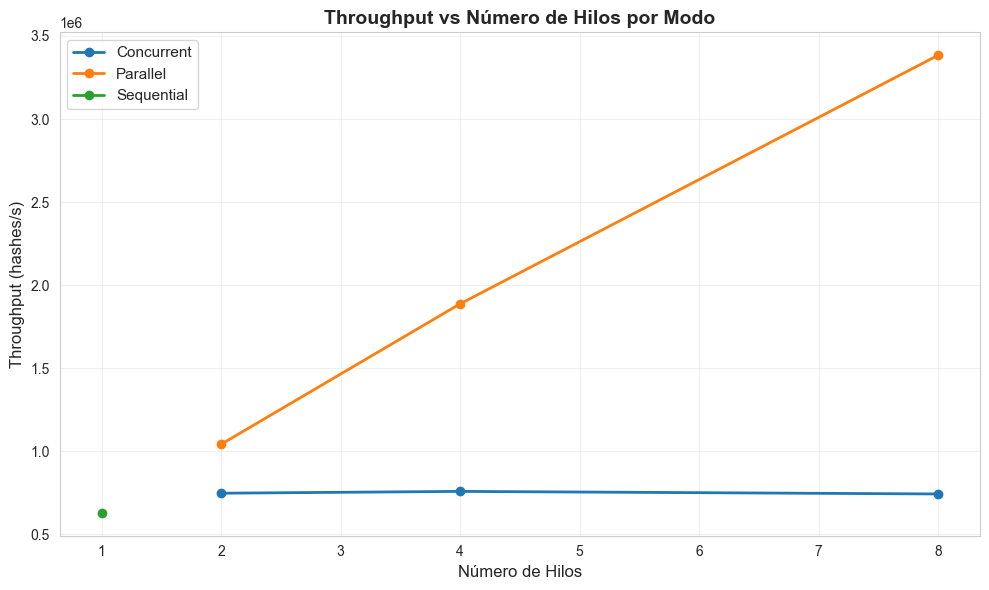

In [14]:
# Análisis por número de hilos
if 'all_data' in locals():
    print("=== ANÁLISIS POR NÚMERO DE HILOS ===")
    
    thread_analysis = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': ['mean', 'std'],
        'run_id': 'count'
    }).round(2)
    
    thread_analysis.columns = ['throughput_mean', 'throughput_std', 'n_runs']
    display(thread_analysis)
    
    # Visualización
    fig, ax = plt.subplots(figsize=(10, 6))
    for mode in all_data['mode'].unique():
        mode_data = all_data[all_data['mode'] == mode]
        thread_means = mode_data.groupby('threads')['throughput_hashes_per_sec'].mean()
        ax.plot(thread_means.index, thread_means.values, marker='o', linewidth=2, label=mode.capitalize())
    
    ax.set_xlabel('Número de Hilos', fontsize=12)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax.set_title('Throughput vs Número de Hilos por Modo', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 4. Speedup y Eficiencia

Cálculo de métricas de paralelización.

Baseline Sequential Throughput: 629,251 hashes/s

=== TABLA DE SPEEDUP Y EFICIENCIA ===


,mode,threads,throughput_hashes_per_sec,speedup,efficiency,efficiency_pct
0,concurrent,2,747413.067,1.188,0.594,59.4
1,concurrent,4,758383.400,1.205,0.301,30.1
2,concurrent,8,742841.400,1.181,0.148,14.8
3,parallel,2,1041841.867,1.656,0.828,82.8
4,parallel,4,1887376.000,2.999,0.750,75.0
5,parallel,8,3384015.333,5.378,0.672,67.2
6,sequential,1,629251.000,1.000,1.000,100.0


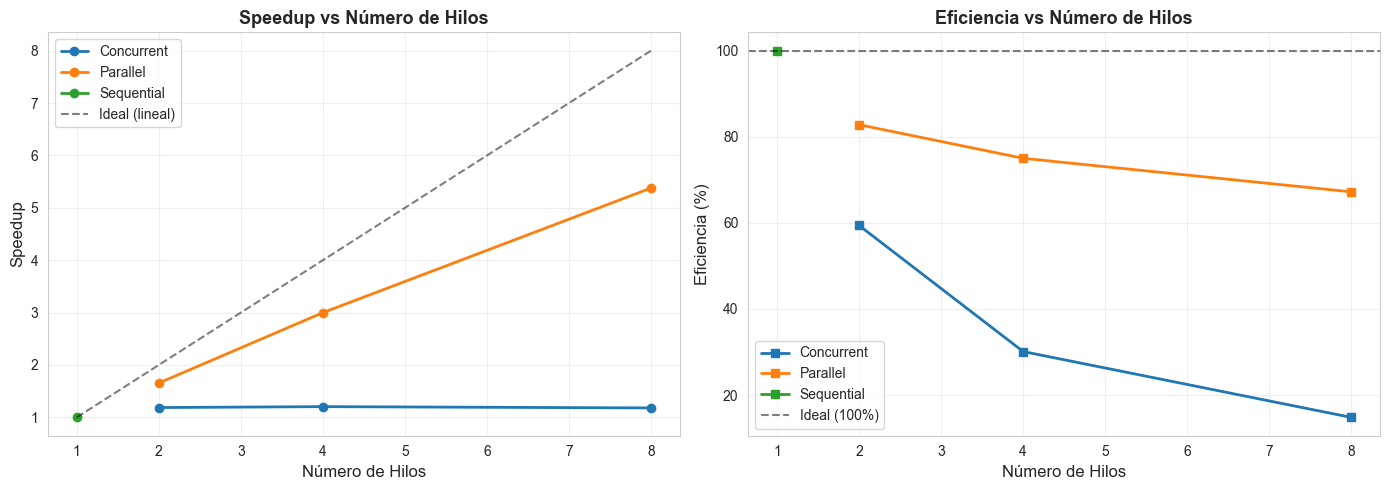

In [15]:
# Calcular speedup y eficiencia
if 'all_data' in locals() and 'sequential' in all_data['mode'].values:
    # Baseline: throughput secuencial
    seq_throughput = all_data[all_data['mode'] == 'sequential']['throughput_hashes_per_sec'].mean()
    print(f"Baseline Sequential Throughput: {seq_throughput:,.0f} hashes/s\n")
    
    # Calcular speedup por configuración
    speedup_data = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': 'mean'
    }).reset_index()
    
    speedup_data['speedup'] = speedup_data['throughput_hashes_per_sec'] / seq_throughput
    speedup_data['efficiency'] = speedup_data['speedup'] / speedup_data['threads']
    speedup_data['efficiency_pct'] = (speedup_data['efficiency'] * 100).round(1)
    
    print("=== TABLA DE SPEEDUP Y EFICIENCIA ===")
    display(speedup_data.round(3))
    
    # Visualización de speedup
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Speedup
    for mode in speedup_data['mode'].unique():
        mode_data = speedup_data[speedup_data['mode'] == mode]
        ax1.plot(mode_data['threads'], mode_data['speedup'], marker='o', linewidth=2, label=mode.capitalize())
    
    ax1.plot([1, speedup_data['threads'].max()], [1, speedup_data['threads'].max()], 
             'k--', alpha=0.5, label='Ideal (lineal)')
    ax1.set_xlabel('Número de Hilos', fontsize=12)
    ax1.set_ylabel('Speedup', fontsize=12)
    ax1.set_title('Speedup vs Número de Hilos', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Eficiencia
    for mode in speedup_data['mode'].unique():
        mode_data = speedup_data[speedup_data['mode'] == mode]
        ax2.plot(mode_data['threads'], mode_data['efficiency_pct'], marker='s', linewidth=2, label=mode.capitalize())
    
    ax2.axhline(y=100, color='k', linestyle='--', alpha=0.5, label='Ideal (100%)')
    ax2.set_xlabel('Número de Hilos', fontsize=12)
    ax2.set_ylabel('Eficiencia (%)', fontsize=12)
    ax2.set_title('Eficiencia vs Número de Hilos', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Análisis Estadístico

Pruebas de significancia estadística entre modos.

In [16]:
# ANOVA para comparar modos
if 'all_data' in locals():
    print("=== ANÁLISIS DE VARIANZA (ANOVA) ===")
    print("H0: Las medias de throughput son iguales entre todos los modos")
    print("H1: Al menos un modo tiene media diferente\n")
    
    # Agrupar datos por modo
    groups = [group['throughput_hashes_per_sec'].values for name, group in all_data.groupby('mode')]
    
    # ANOVA
    f_stat, p_value = stats.f_oneway(*groups)
    
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.6f}")
    
    if p_value < 0.001:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.001)")
        print("   Las diferencias entre modos son estadísticamente significativas.")
    elif p_value < 0.05:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.05)")
        print("   Las diferencias entre modos son estadísticamente significativas.")
    else:
        print("\n❌ Resultado: NO SIGNIFICATIVO (p >= 0.05)")
        print("   No hay evidencia suficiente de diferencias entre modos.")

=== ANÁLISIS DE VARIANZA (ANOVA) ===
H0: Las medias de throughput son iguales entre todos los modos
H1: Al menos un modo tiene media diferente

F-statistic: 59.0603
P-value: 0.000000

✅ Resultado: SIGNIFICATIVO (p < 0.001)
   Las diferencias entre modos son estadísticamente significativas.


In [17]:
# Test de Kruskal-Wallis (no paramétrico)
if 'all_data' in locals():
    print("\n=== TEST DE KRUSKAL-WALLIS (No Paramétrico) ===")
    print("Alternativa robusta cuando los datos no siguen distribución normal\n")
    
    h_stat, p_value_kw = stats.kruskal(*groups)
    
    print(f"H-statistic: {h_stat:.4f}")
    print(f"P-value: {p_value_kw:.6f}")
    
    if p_value_kw < 0.001:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.001)")
    elif p_value_kw < 0.05:
        print("\n✅ Resultado: SIGNIFICATIVO (p < 0.05)")
    else:
        print("\n❌ Resultado: NO SIGNIFICATIVO (p >= 0.05)")


=== TEST DE KRUSKAL-WALLIS (No Paramétrico) ===
Alternativa robusta cuando los datos no siguen distribución normal

H-statistic: 77.7609
P-value: 0.000000

✅ Resultado: SIGNIFICATIVO (p < 0.001)


In [18]:
# Comparaciones por pares (Mann-Whitney U con corrección de Bonferroni)
if 'all_data' in locals():
    print("\n=== COMPARACIONES POR PARES (Mann-Whitney U) ===")
    print("Con corrección de Bonferroni para múltiples comparaciones\n")
    
    modes = all_data['mode'].unique()
    n_comparisons = len(modes) * (len(modes) - 1) // 2
    alpha_corrected = 0.05 / n_comparisons
    
    print(f"Nivel de significancia ajustado: α = {alpha_corrected:.4f}\n")
    
    pairwise_results = []
    
    for i, mode1 in enumerate(modes):
        for mode2 in modes[i+1:]:
            data1 = all_data[all_data['mode'] == mode1]['throughput_hashes_per_sec']
            data2 = all_data[all_data['mode'] == mode2]['throughput_hashes_per_sec']
            
            u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
            
            mean_diff = data1.mean() - data2.mean()
            pct_diff = (mean_diff / data2.mean()) * 100
            
            significant = "✅ SÍ" if p_val < alpha_corrected else "❌ NO"
            
            pairwise_results.append({
                'Comparación': f"{mode1} vs {mode2}",
                'Diff Media': f"{mean_diff:,.0f}",
                'Diff %': f"{pct_diff:+.1f}%",
                'U-statistic': f"{u_stat:.1f}",
                'p-value': f"{p_val:.6f}",
                'Significativo': significant
            })
    
    pairwise_df = pd.DataFrame(pairwise_results)
    display(pairwise_df)


=== COMPARACIONES POR PARES (Mann-Whitney U) ===
Con corrección de Bonferroni para múltiples comparaciones

Nivel de significancia ajustado: α = 0.0167



,Comparación,Diff Media,Diff %,U-statistic,p-value,Significativo
0,concurrent vs parallel,"-1,354,865",-64.4%,0.0,0.000000,✅ SÍ
1,concurrent vs sequential,"120,295",+19.1%,456.0,0.043963,❌ NO
2,parallel vs sequential,"1,475,160",+234.4%,675.0,0.000000,✅ SÍ


## 6. Visualizaciones

Gráficas comparativas detalladas.

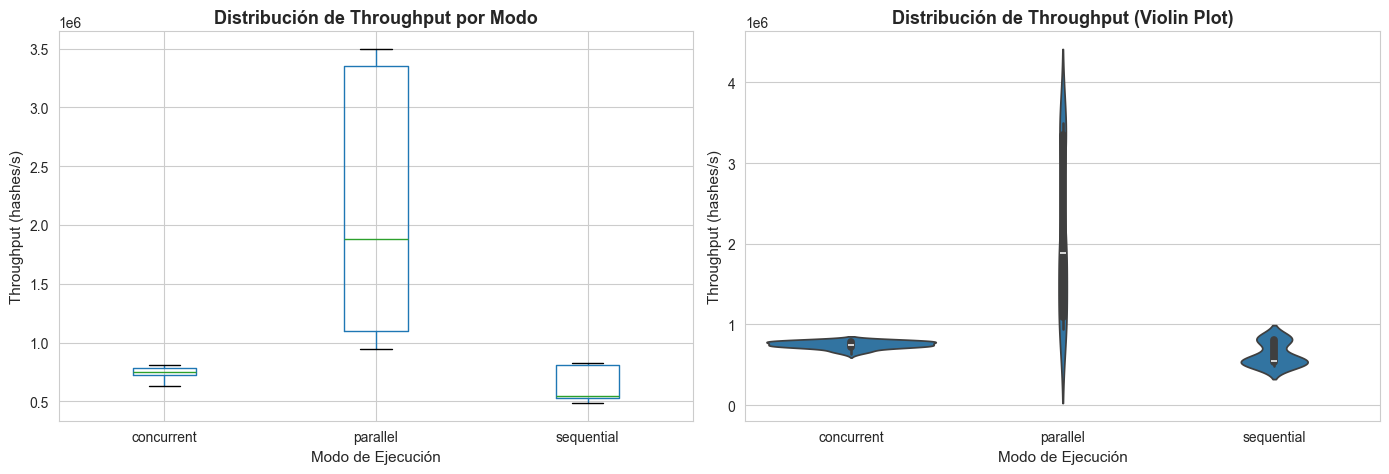

In [19]:
# Boxplot de throughput por modo
if 'all_data' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Boxplot
    all_data.boxplot(column='throughput_hashes_per_sec', by='mode', ax=ax1)
    ax1.set_title('Distribución de Throughput por Modo', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Modo de Ejecución', fontsize=11)
    ax1.set_ylabel('Throughput (hashes/s)', fontsize=11)
    plt.suptitle('')  # Remover título automático
    
    # Violin plot
    sns.violinplot(data=all_data, x='mode', y='throughput_hashes_per_sec', ax=ax2)
    ax2.set_title('Distribución de Throughput (Violin Plot)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Modo de Ejecución', fontsize=11)
    ax2.set_ylabel('Throughput (hashes/s)', fontsize=11)
    
    plt.tight_layout()
    plt.show()

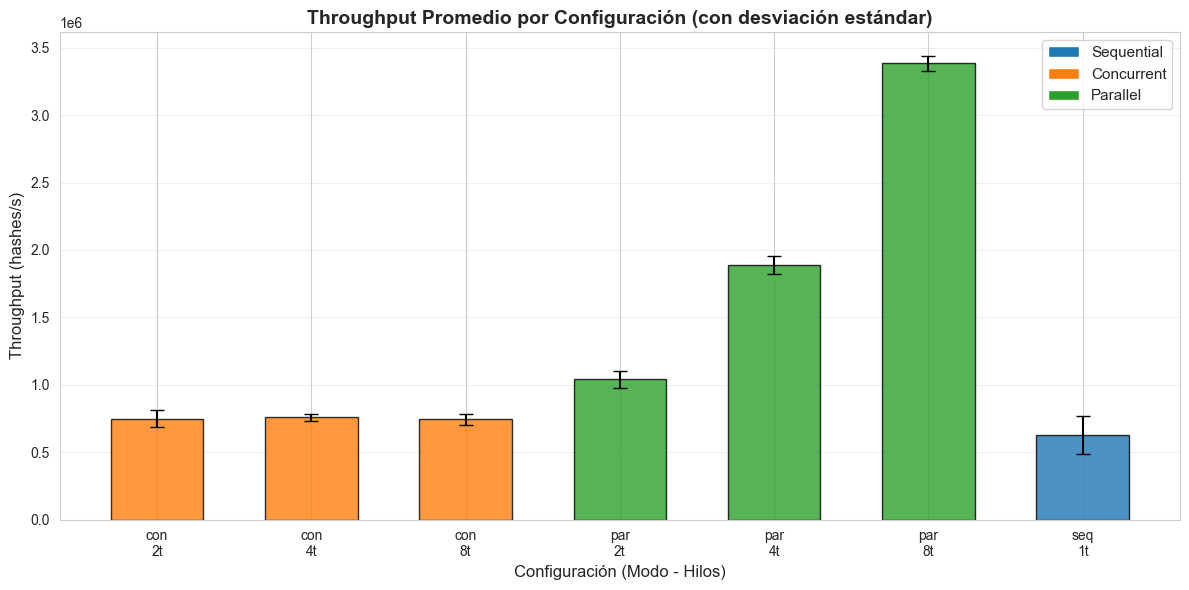

In [20]:
# Gráfico de barras con error bars
if 'all_data' in locals():
    summary_stats = all_data.groupby(['mode', 'threads']).agg({
        'throughput_hashes_per_sec': ['mean', 'std']
    }).reset_index()
    
    summary_stats.columns = ['mode', 'threads', 'mean', 'std']
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(summary_stats))
    width = 0.6
    
    colors = {'sequential': '#1f77b4', 'concurrent': '#ff7f0e', 'parallel': '#2ca02c'}
    bar_colors = [colors.get(mode, 'gray') for mode in summary_stats['mode']]
    
    bars = ax.bar(x, summary_stats['mean'], width, yerr=summary_stats['std'], 
                  capsize=5, color=bar_colors, alpha=0.8, edgecolor='black')
    
    ax.set_xlabel('Configuración (Modo - Hilos)', fontsize=12)
    ax.set_ylabel('Throughput (hashes/s)', fontsize=12)
    ax.set_title('Throughput Promedio por Configuración (con desviación estándar)', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{row['mode'][:3]}\n{int(row['threads'])}t" 
                        for _, row in summary_stats.iterrows()], fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    
    # Leyenda
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=mode.capitalize()) 
                      for mode, color in colors.items()]
    ax.legend(handles=legend_elements, fontsize=11)
    
    plt.tight_layout()
    plt.show()

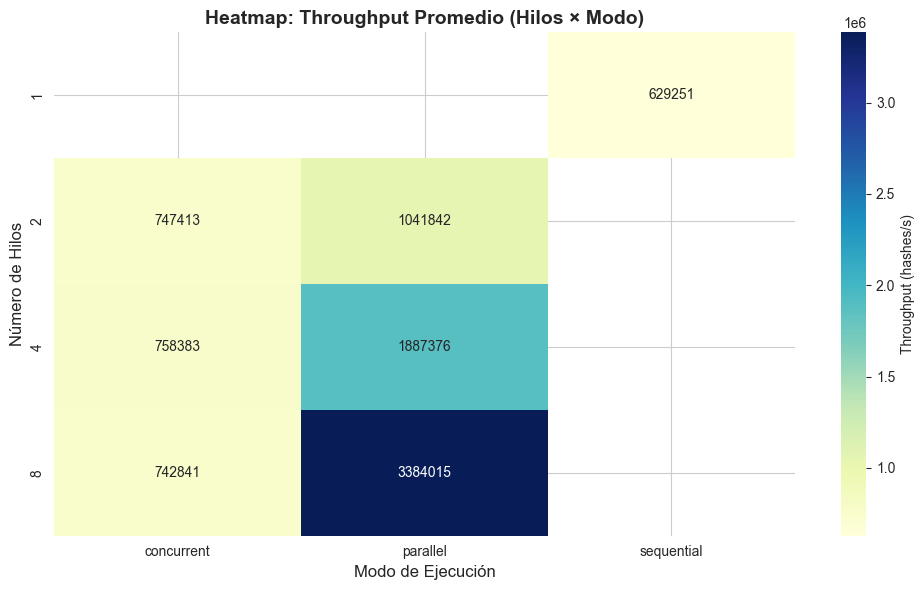

In [21]:
# Heatmap de throughput
if 'all_data' in locals():
    pivot_data = all_data.pivot_table(
        values='throughput_hashes_per_sec',
        index='threads',
        columns='mode',
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlGnBu', 
                cbar_kws={'label': 'Throughput (hashes/s)'}, ax=ax)
    ax.set_title('Heatmap: Throughput Promedio (Hilos × Modo)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Modo de Ejecución', fontsize=12)
    ax.set_ylabel('Número de Hilos', fontsize=12)
    plt.tight_layout()
    plt.show()

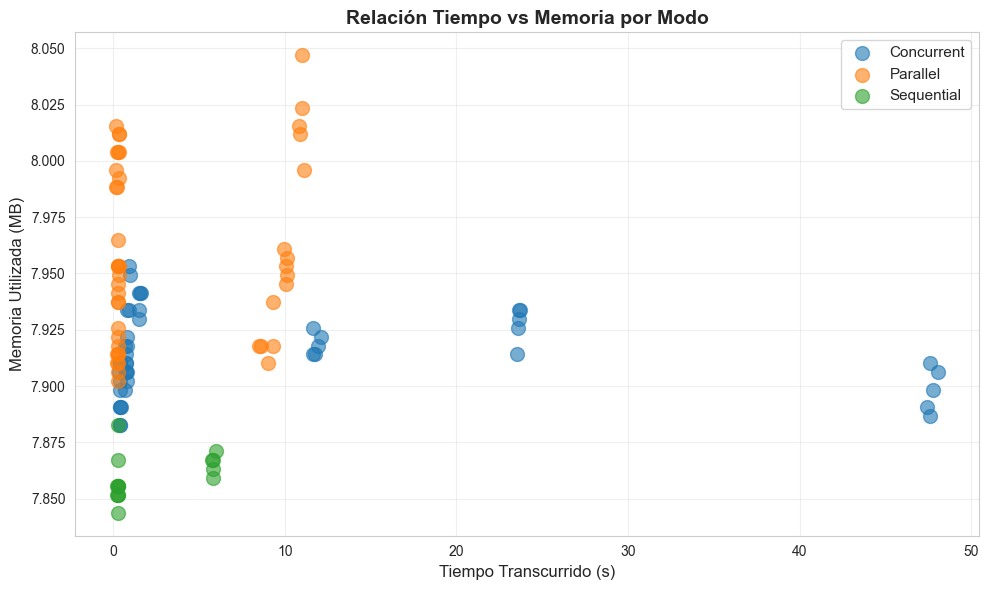

In [22]:
# Análisis de tiempo vs memoria
if 'all_data' in locals():
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for mode in all_data['mode'].unique():
        mode_data = all_data[all_data['mode'] == mode]
        ax.scatter(mode_data['elapsed_time_s'], mode_data['memory_mb'], 
                  alpha=0.6, s=100, label=mode.capitalize())
    
    ax.set_xlabel('Tiempo Transcurrido (s)', fontsize=12)
    ax.set_ylabel('Memoria Utilizada (MB)', fontsize=12)
    ax.set_title('Relación Tiempo vs Memoria por Modo', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Conclusiones
### Resumen Ejecutivo

In [25]:
# Generar resumen de conclusiones
if 'all_data' in locals() and 'speedup_data' in locals():
    print("=" * 70)
    print("RESUMEN EJECUTIVO - ANÁLISIS DE RENDIMIENTO")
    print("=" * 70)
    
    # Mejor configuración
    best_config = speedup_data.loc[speedup_data['throughput_hashes_per_sec'].idxmax()]
    print(f"\n✅ MEJOR CONFIGURACIÓN:")
    print(f"   Modo: {best_config['mode'].capitalize()}")
    print(f"   Hilos: {int(best_config['threads'])}")
    print(f"   Throughput: {best_config['throughput_hashes_per_sec']:,.0f} hashes/s")
    print(f"   Speedup: {best_config['speedup']:.2f}×")
    print(f"   Eficiencia: {best_config['efficiency_pct']:.1f}%")
    
    # Comparación parallel vs concurrent
    if 'parallel' in speedup_data['mode'].values and 'concurrent' in speedup_data['mode'].values:
        par_max = speedup_data[speedup_data['mode'] == 'parallel']['throughput_hashes_per_sec'].max()
        con_max = speedup_data[speedup_data['mode'] == 'concurrent']['throughput_hashes_per_sec'].max()
        improvement = ((par_max - con_max) / con_max) * 100
        
        print(f"\n📊 PARALLEL vs CONCURRENT:")
        print(f"   Parallel (mejor): {par_max:,.0f} hashes/s")
        print(f"   Concurrent (mejor): {con_max:,.0f} hashes/s")
        print(f"   Mejora: {improvement:+.1f}%")

    
    print(f"   ✓ El escalamiento es eficiente hasta {int(speedup_data['threads'].max())} hilos")
    
    print("\n" + "=" * 70)

RESUMEN EJECUTIVO - ANÁLISIS DE RENDIMIENTO

✅ MEJOR CONFIGURACIÓN:
   Modo: Parallel
   Hilos: 8
   Throughput: 3,384,015 hashes/s
   Speedup: 5.38×
   Eficiencia: 67.2%

📊 PARALLEL vs CONCURRENT:
   Parallel (mejor): 3,384,015 hashes/s
   Concurrent (mejor): 758,383 hashes/s
   Mejora: +346.2%
   ✓ El escalamiento es eficiente hasta 8 hilos

